In [46]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from biodata.delimited import DelimitedReader, DelimitedWriter
import numpy as np
import pyBigWig
from collections import defaultdict
import seaborn as sns
import itertools
from biodatatools.utils.common import json_dump
from statannotations.Annotator import Annotator
from scipy.stats import ks_2samp
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [33]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# DE analysis

In [5]:
s = "HCT116"
factor = "CTCF"
ks = ["pl", "mn"]
ts = ["minTSS", "maxTSS"]
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
gs = [f"{p}_{d}" for p, d in itertools.product(ps, ds)]
labels = ["Up", "Unchanged", "Down"]

## Metadata

In [6]:
df_metadata = pd.DataFrame({"Condition": ["U", "U", "T", "T"]}, columns=["Condition"], index=["U1", "U2", "T1", "T2"])
outputfile = f"{PROJECT_DIR_o}DE/{s}_metadata.txt"
df_metadata.to_csv(outputfile, sep="\t")

## Count data

In [7]:
reps = list(df_metadata.index)
bws = {}
for r in reps:
	bws[r] = [f"{PROJECT_DIR_d}Alignments/{factor}_{r}_5{k}.bw" for k in ks]

In [8]:
results = []
index = []
for g in gs:
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	df = pd.read_table(inputfile, header=None)
	for _, row in df.iterrows():
		chrom, start, end = row[:3]
		sign = row[7]
		for t in ts:
			index.append("_".join([chrom, str(start), str(end), t, g]))
			row = []
			for r in bws:
				pl, mn = bws[r]
				bw1 = pyBigWig.open(pl)
				bw2 = pyBigWig.open(mn)
				reads1 = 0
				reads2 = 0
				
				if bw1.intervals(chrom, start, end) != None:
					for start2, end2, score in bw1.intervals(chrom, start, end):
						l = min(end, end2) - max(start, start2)
						reads1 += abs(score) * l
				if bw2.intervals(chrom, start, end) != None:
					for start2, end2, score in bw2.intervals(chrom, start, end):
						l = min(end, end2) - max(start, start2)
						reads2 += abs(score) * l
			
				if t == "maxTSS":
					row.append(reads1 if sign == "+" else reads2)
				else:
					row.append(reads2 if sign == "+" else reads1)
			results.append(row)
			
df_counts = pd.DataFrame(results, columns=reps, index=index)
outputfile = f"{PROJECT_DIR_o}DE/{s}_counts.txt"
df_counts.to_csv(outputfile, sep="\t")

## Run DESeq2

In [9]:
# Run DESeq2 in "2-2.DESeq2.ipynb" (also see explanation of NA values there)

inputfile = f"{PROJECT_DIR_o}DE/{s}_DEseq2_R.txt"
res = pd.read_table(inputfile)
res = res.dropna()
res.head(2)

,baseMean,log2FoldChange,lfcSE,pvalue,padj
chr1_998781_999282_minTSS_divergent_distal,6.822060,0.015648,0.203724,0.679041,0.999902
chr1_998781_999282_maxTSS_divergent_distal,84.714796,0.002141,0.059231,0.823821,0.999902


In [10]:
padj_cutoff = 0.05
lfc_cutoff = np.log2(1.5)
conditions = [
	(res["padj"] < padj_cutoff) & (res["log2FoldChange"] > lfc_cutoff),
	(res["padj"] < padj_cutoff) & (res["log2FoldChange"] < -lfc_cutoff),
]
choices = ["Up", "Down"]
res["Label"] = np.select(conditions, choices, default="Unchanged")

## Volcano plot

In [53]:
def volcano_plot(res, d, t, loc, outputfile):
	fig, ax = plt.subplots(figsize=(3.2,2.8))
	res2 = res[res.index.str.contains(d) & res.index.str.contains(t)].copy()
	res2["-log10padj"] = -np.log10(res2["padj"])
	g = sns.scatterplot(data=res2, x="log2FoldChange", y="-log10padj", 
						hue="Label", hue_order=labels,
						palette=["#FFD700","#d9d9d9","#b3de69"], 
						alpha=0.7, s=30, ax=ax)
	g.spines[["right", "top"]].set_visible(False)
	g.set_title(t, fontsize=bfontsize, pad=5)
	
	g.set_yticks([0,10,20,30,40])
	g.set_ylim([-2,48])
	g.set_ylabel(r"-log$_{10}$(q-value)", fontsize=bfontsize)

	g.set_xlim([-8, 8])
	g.set_xlabel(r"log$_2$(T/UT)", fontsize=bfontsize)
	
	g.tick_params(labelsize=sfontsize)
	
	legend = g.legend(loc=loc, frameon=False, handletextpad=0, labelspacing=0.3)
	for label in labels:
		legend.get_texts()[labels.index(label)].set_text(label+" (n=" + str(len(res2[res2["Label"]==label])) + ")")
		legend.get_texts()[labels.index(label)].set_fontsize(sfontsize)
		
	plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True) 

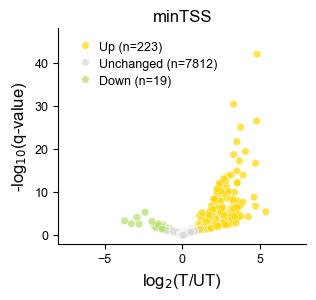

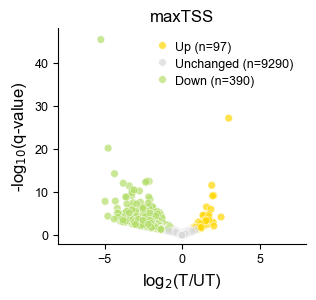

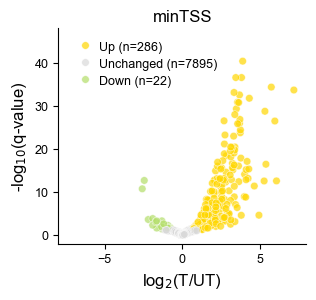

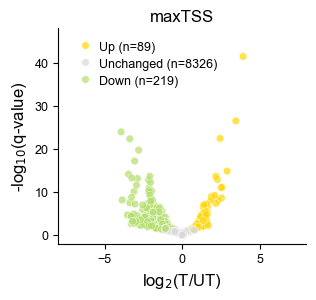

In [54]:
for d, t in itertools.product(ds, ts):
	loc = "upper right" if t == "maxTSS" and d == "distal" else "upper left"
	if d == "distal":
		outputfile = f"{PROJECT_DIR_o}figures/Fig4c.png" if t == "minTSS" else f"{PROJECT_DIR_o}figures/Fig4e.png"
	else:
		outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig11a.png" if t == "minTSS" else f"{PROJECT_DIR_o}figures/ExtDataFig11c.png"
	volcano_plot(res, d, t, loc, outputfile)

In [13]:
# Get labels for each element

DE_labels = defaultdict(dict)
for t, g in itertools.product(ts, gs):
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	with DelimitedReader(inputfile) as dr:
		for cols in dr:
			chrom, start, end = cols[:3]
			e = "_".join([chrom, start, end, t, g])
			if e in res.index:
				DE_labels[t]["_".join([chrom, start, end])] = res.loc[e]["Label"]

In [14]:
json_dump(f"{PROJECT_DIR_o}labels/{s}_{factor}_DE.json", DE_labels)

# minTSS vs. maxTSS

## Categorical comparison

In [15]:
effects = defaultdict(dict)
for d, t in itertools.product(ds, ts):
	res2 = res[res.index.str.contains(d) & res.index.str.contains(t)].copy()
	for label in labels:
		effects[(d,t)][label] = set(["_".join(e.split("_")[:3]) for e in res2[res2["Label"]==label].index])

In [16]:
# Elements with non-NA values in both sides

shared = {}
for d in ds:
	shared[d] = set().union(*effects[(d, "minTSS")].values()) & set().union(*effects[(d, "maxTSS")].values())

In [74]:
def plot_prop(d, group, lbs, effects, outputfile):
	row_group, col_group = group
	fig, ax = plt.subplots(figsize=(2.5,1))
	ax.axis('off')
	ax.axis('tight')
	
	results = []
	for label in lbs:
		row = []
		ns = [len(effects[(d, row_group)][label] & effects[(d, col_group)][label2] & shared[d]) for label2 in labels]
		ratios = []
		for n in range(3):
			if n != 2:
				ratios.append(round(ns[n]/sum(ns)*100,1))
				row.append(f"{ns[n]} ({ratios[n]}%)")
			else:
				row.append(f"{ns[n]} ({round(100-sum(ratios),1)}%)")
		results.append(row)
		
	colors = {"minTSS": "#a6cee3", "maxTSS": "#fb9a99"}
	rowColours=[colors[row_group]]*3
	colColours=[colors[col_group]]*3
	table = ax.table(cellText=results,
			  rowLabels=lbs,
			  rowColours=rowColours,
			  rowLoc="center",
			  colLabels=labels,
			  colColours=colColours,
			  colLoc="center",
			  cellLoc="center",
			  loc="center",
			  )
	table.scale(1.3, 3.5)
	
	table.auto_set_font_size(False)
	for (row, col), cell in table.get_celld().items():
		if (row == 0) or (col == -1):
			cell.set_text_props(fontproperties=FontProperties(size=sfontsize))
		else:
			cell.set_text_props(fontproperties=FontProperties(size=sfontsize))

	colors2 = {"minTSS": "#08519c", "maxTSS": "#a50f15"}
	ax.text(x=0, y=0.19, s=col_group, fontsize=bfontsize, ha="center", color=colors2[col_group])
	ax.text(x=-0.135, y=-0.04, s=row_group, fontsize=bfontsize, va="center", rotation=90, color=colors2[row_group])

	plt.savefig(outputfile, bbox_inches="tight", transparent=True) 

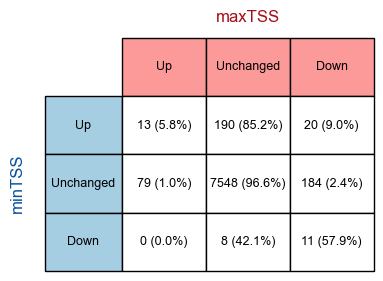

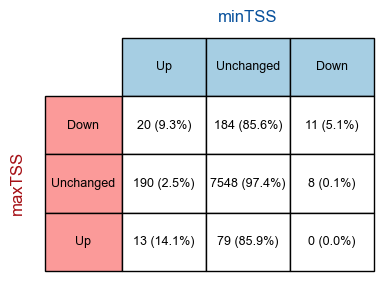

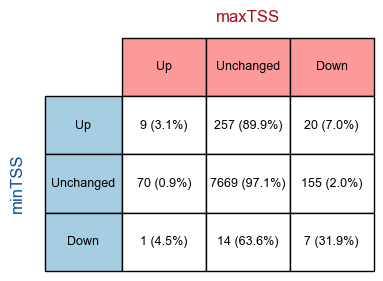

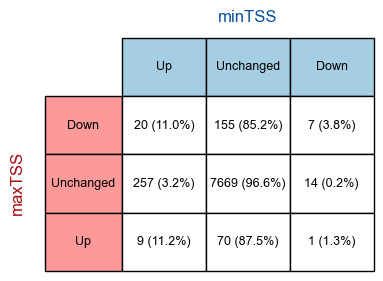

In [75]:
groups = [["minTSS", "maxTSS"], ["maxTSS", "minTSS"]]
lbs = [["Up", "Unchanged", "Down"], ["Down", "Unchanged", "Up"]]
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	for group, lb in zip(groups, lbs):
		if groups.index(group) == 0:
			outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig9a.pdf"
		else:
			outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig9b.pdf"
		plot_prop(d, group, lb, effects, outputfile)

## log2FC

In [19]:
# Get log2FC for each elements

fcs = defaultdict(dict)
for index, row in res.iterrows():
	chrom, start, end, t, p, d = index.split("_")
	e = "_".join([chrom, start, end])
	if e in shared[d]:
		fcs[d][(e,t)] = [row["log2FoldChange"], row["Label"]]

In [20]:
results = []
for d in ds:
	for e in shared[d]:
		results.append([d, e] + [v for t in ts for v in fcs[d][(e, t)]])		
columns = ["group", "element"] 
for t in ts:
	columns.extend([f"{t}_FC", t])
df_fc = pd.DataFrame(results, columns=columns)
df_fc.head(2)

,group,element,minTSS_FC,minTSS,maxTSS_FC,maxTSS
0,distal,chr12_89354432_89354933,-0.000627,Unchanged,0.026589,Unchanged
1,distal,chr14_100417452_100417953,-0.009124,Unchanged,0.021786,Unchanged


In [76]:
def plot_log2FC(d, t, df, outputfile):
	fig, ax = plt.subplots(figsize=(4,4))
	if t == "minTSS":
		lbs = ["Up", "Unchanged", "Down"]
		palette = ["#FFD700","#d9d9d9","#b3de69"]
	else:
		lbs = ["Down", "Unchanged","Up"]
		palette = ["#b3de69","#d9d9d9","#FFD700"]
	df = df[(df[t].isin(lbs)) & (df["group"]==d)]
	g = sns.scatterplot(data=df, x="minTSS_FC", y="maxTSS_FC", hue=t, 
						hue_order=lbs, palette=palette, s=30, alpha=0.7, ax=ax)
	g.spines[["right", "top"]].set_visible(False)
	g.legend_.set_title(t, prop={"size":sfontsize})
	for text in g.legend_.get_texts():
		text.set_fontsize(sfontsize)

	g.set_ylim([-8.5,8.5])
	g.set_yticks([-8,-4,0,4,8])
	g.set_ylabel("log$_2$FC (maxTSS)", fontsize=bfontsize)
		
	g.set_xlim([-8.5,8.5])
	g.set_xticks([-8,-4,0,4,8])
	g.set_xlabel("log$_2$FC (minTSS)", fontsize=bfontsize)

	g.tick_params(labelsize=sfontsize)

	plt.savefig(outputfile, bbox_inches='tight', dpi=300, transparent=True) 

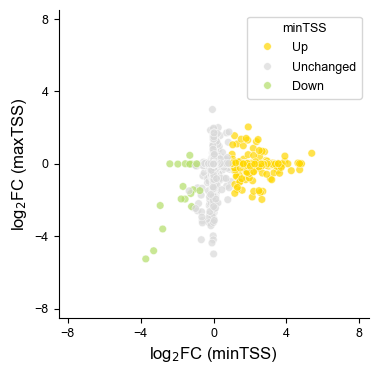

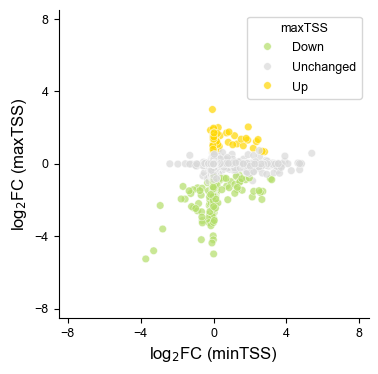

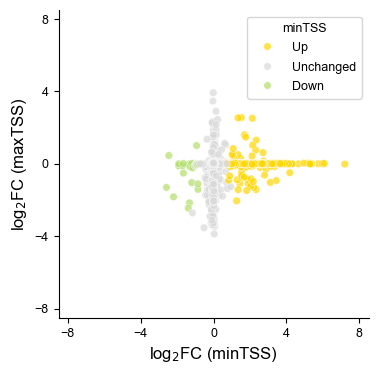

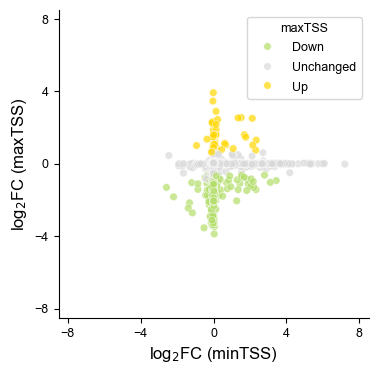

In [77]:
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	for t in ts:
		if t == "minTSS":
			outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig9c.png"
		else:
			outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig9d.png"
		plot_log2FC(d, t, df_fc, outputfile)

## Directionality index changes

In [55]:
bws2 = {"UT": [f"{PROJECT_DIR_d}Alignments/brm_{factor}_U1_and_{factor}_U2_erm_5{k}.bw" for k in ks],
	   "T": [f"{PROJECT_DIR_d}Alignments/brm_{factor}_T1_and_{factor}_T2_erm_5{k}.bw" for k in ks]
	  }

In [24]:
def get_DI(bws, es):
	pl, mn = bws
	bw1 = pyBigWig.open(pl)
	bw2 = pyBigWig.open(mn)
	
	DIs = {}
	for e in es:
		reads1 = 0
		reads2 = 0
		chrom, start, end = e.split("_")
		start = int(start)
		end = int(end)
		if bw1.intervals(chrom, start, end) != None:
			for start2, end2, score in bw1.intervals(chrom, start, end):
				l = min(end, end2) - max(start, start2)
				reads1 += abs(score) * l
		if bw2.intervals(chrom, start, end+1) != None:
			for start2, end2, score in bw2.intervals(chrom, start, end):
				l = min(end, end2) - max(start, start2)
				reads2 += abs(score) * l
		if reads1+reads2 > 0:
			DIs[e] = (reads1-reads2)/(reads1+reads2)
	return DIs

In [56]:
DIs = {}
for d in ds:
	for k in bws2:
		DIs[(d,k)] = get_DI(bws2[k], shared[d])

In [57]:
results = []
for d in ds:
	for e in shared[d]:
		results.extend([[d, e, DIs[(d,k)][e], k] for k in bws2])
df_DI = pd.DataFrame(results, columns=["group", "element", "DI", "time"])
df_DI.head(2)

,group,element,DI,time
0,distal,chr12_89354432_89354933,0.47561,UT
1,distal,chr12_89354432_89354933,0.60000,T


In [58]:
df_merged = df_DI.merge(df_fc, on=["group", "element"])
df_merged.head(2)

,group,element,DI,time,minTSS_FC,minTSS,maxTSS_FC,maxTSS
0,distal,chr12_89354432_89354933,0.47561,UT,-0.000627,Unchanged,0.026589,Unchanged
1,distal,chr12_89354432_89354933,0.60000,T,-0.000627,Unchanged,0.026589,Unchanged


In [62]:
def plot_DI_changes(d, t, df_merged, outputfile):
	fig, ax = plt.subplots(figsize=(4,3.5))
	if t == "minTSS":
		l = "Up"
		colors = ["#FFD700"]*2
	else:
		l = "Down"
		colors = ["#b3de69"]*2

	df = df_merged[(df_merged["group"]==d) & (df_merged[t]==l)]
	hue_plot_params = {
				"data": df,
				"x": "time",
				"y": "DI",
				"hue": "time",
				"palette": colors,
				"legend": False,
				"cut": 0
			}
	g = sns.violinplot(ax=ax, **hue_plot_params)
	for violin, alpha in zip(g.collections[::2], [0.5,1]):
	    violin.set_alpha(alpha)
	g.spines[["right", "top"]].set_visible(False)
	
	g.set_ylabel("Directionality index", fontsize=bfontsize)
	g.set_yticks([-1,-0.5,0,0.5,1])
	g.tick_params(axis="y", labelsize=sfontsize)

	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize)

	group1 = list(df[df["time"]=="UT"]["DI"])
	group2 = list(df[df["time"]=="T"]["DI"])
	pvalue = ks_2samp(group1, group2)[1]
	annotator = Annotator(g, [["UT", "T"]], **hue_plot_params)
	annotator.configure(text_format="star", verbose=False, text_offset=1, loc="outside")
	annotator.set_pvalues([pvalue]).annotate()	

	plt.savefig(outputfile, bbox_inches = 'tight', transparent=True) 

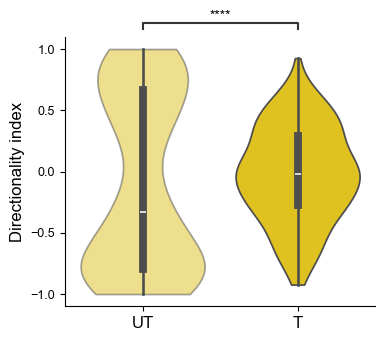

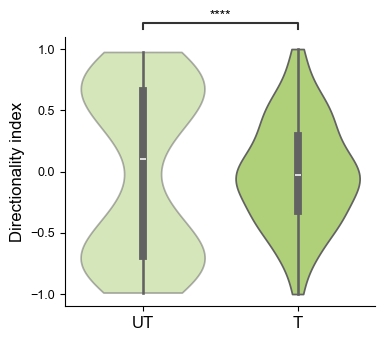

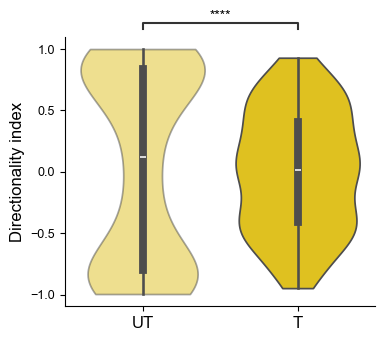

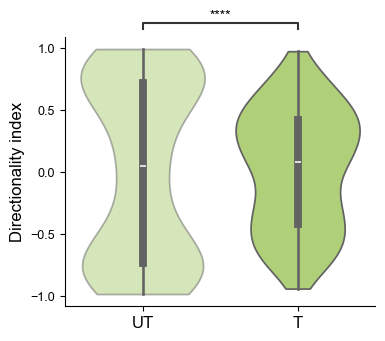

In [63]:
for d, t in itertools.product(ds, ts):
	n = 9 if d == "distal" else 11
	if t == "minTSS":
		outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig{n}e.pdf"
	else:
		outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig{n}f.pdf"
	plot_DI_changes(d, t, df_merged, outputfile)